In [2]:
from symred.symplectic_form import PauliwordOp
from symred.S3_projection import (S3_projection, 
                                  gf2_gaus_elim, 
                                  gf2_basis_for_gf2_rref, 
                                  QubitTapering, 
                                  CS_VQE, 
                                  CheatS_VQE)
from symred.build_model import build_molecule_for_projection
from symred.utils import get_ground_state
import json
import numpy as np
import openfermion as of
import openfermionpyscf as ofpyscf
from openfermion.circuits import ( uccsd_singlet_get_packed_amplitudes,
                                   uccsd_singlet_generator, uccsd_generator,
                                   uccsd_convert_amplitude_format)
from itertools import combinations, product

In [3]:
with open('molecule_geometries/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3G_SINGLET', 'CHONH2_STO-3G_SINGLET', 'CO2_STO-3G_SINGLET', 'O2_STO-3G_SINGLET', 'O3_STO-3G_SINGLET', 'HO

In [7]:
# Set molecule parameters
speciesname = 'Be_STO-3G_SINGLET'
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms = mol_data['atoms']
coords = mol_data['coords']
basis = mol_data['basis']
multiplicity = mol_data['multiplicity']
charge = mol_data['charge']
geometry = list(zip(atoms, coords))

delete_input = True
delete_output = True
cisd=1
ccsd=1
fci =1 # wouldn't advise turning this on over 32 qubits!

# Run pyscf.
molecule_data = of.MolecularData(geometry, basis, multiplicity, charge)
calculated_molecule = ofpyscf.run_pyscf(molecule_data,
                     run_scf=1,run_mp2=1,run_cisd=cisd,run_ccsd=ccsd,run_fci=fci)

In [8]:
model = build_molecule_for_projection(calculated_molecule)

------------------------------------------------
Information concerning the full system:
------------------------------------------------
Number of qubits in full problem: 10
The Hartree-Fock state is |1111000000>
HF   energy = -14.35188048
MP2  energy = -14.37623885
CISD energy = -14.40364578
CCSD energy = -14.40365075
FCI energy  = -14.40365511
------------------------------------------------
Tapering information:
------------------------------------------------
We are able to taper 5 qubits from the Hamiltonian
The symmetry sector is:
 1.00000000 ZIZIIZIZIZ +
 1.00000000 IZIZIZIZIZ +
 1.00000000 IIIIZZIIII +
 1.00000000 IIIIIIZZII +
 1.00000000 IIIIIIIIZZ
The tapered Hartree-Fock state is |11000>
------------------------------------------------
CS-VQE information:
------------------------------------------------
Noncontextual GS energy: -14.351880476202028
Symmetry generators:    
-1.00000000 ZIIII +
 1.00000000 IIZII +
 1.00000000 IIIZI +
 1.00000000 IIIIZ
Clique representatives: 


In [9]:
print(get_ground_state(model.ham.to_sparse_matrix)[0])
true_gs = get_ground_state(model.ham_tap.to_sparse_matrix)[0]
print(true_gs)

-14.403655108067637
-14.403655108067706


In [15]:
from itertools import product, combinations
from symred.symplectic_form import StabilizerOp

print(np.sum(np.square(model.ham_tap.coeff_vec)))
cheat = CheatS_VQE(operator=model.ham_tap, ref_state=model.hf_tapered, target_sqp='Z')

N=2
reconum,commute,sor_sum,abs_sum,errors = [],[],[],[],[]
samples=[]
for comb in range(500):
    Z_block = np.random.randint(0,2,(N, model.ham_tap.n_qubits))
    basis_symp = np.hstack([np.zeros_like(Z_block), Z_block])
    try:
        basis = StabilizerOp(basis_symp, np.ones(N))
        projected = cheat.project_onto_subspace(basis)
        nrg = get_ground_state(projected.to_sparse_matrix)[0]
        
        sor_val = cheat.weighted_objective(basis, model.sor_tap)
        abs_val = cheat.weighted_objective(basis)
        sor_sum.append(sor_val)
        abs_sum.append(abs_val)
        commute.append(np.count_nonzero(np.all(model.sor_tap.commutes_termwise(basis), axis=1)))
        errors.append(nrg-true_gs)
        reconum.append(np.count_nonzero(model.ham_tap.basis_reconstruction(basis)))
        samples.append([basis, nrg-true_gs])
    except:
        pass

basis, error = sorted(samples, key=lambda x:x[1])[0]
print(error)
print(basis)

(87.29431830869024+0j)
0.000326505933868404
 1.00000000+0.00000000j ZZIII +
 1.00000000+0.00000000j ZIZZZ


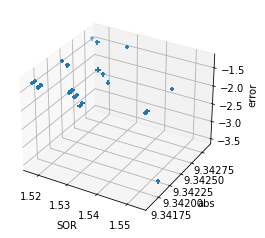

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(sor_sum,abs_sum,np.log10(errors), marker='+')
#ax.hlines(np.log10(0.0016), min(sor_sum), max(sor_sum), color='green')
ax.set_xlabel('SOR')
ax.set_ylabel('abs')
ax.set_zlabel('error')

plt.show()

In [19]:
#samples=[]
#for a,b,c,d in combinations(product([0,1], repeat=8), r=4):
#    try:
#        basis = StabilizerOp(np.array([a,b,c,d]), [1,1,1,1])
#        projected = cheat.project_onto_subspace(basis)
#        nrg = get_ground_state(projected.to_sparse_matrix)[0]
#        print(nrg-true_gs)
#        sor_val = cheat.weighted_objective(basis, model.sor_tap)
#        sample.append([basis, nrg-true_gs, sor_val])
#    except:
#        pass

In [20]:
cheat.weighted_objective(basis, model.sor_tap)

(1.5533836426265828+0j)

In [ ]:
from quantumtools.Hamiltonian import QubitHamiltonian, HamiltonianGraph

In [ ]:
terms, coeffs = zip(*model.ham_tap.to_dictionary.items())
terms, coeffs = list(terms), list(coeffs)
graph = HamiltonianGraph(terms, coeffs)
g_dict = graph.clique_cover('C', 'largest_first')
largest_C_set = sorted(g_dict.items(), key=lambda x:-x[1].n_terms)[0][1]

In [ ]:
print(largest_C_set)

In [ ]:
basis = StabilizerOp(['IXIII', 'ZIZZZ', 'IZZII', 'IIZII', 'IIZZI', 'IIIZZ'],[1,1,1,1,1,1])
print(basis)
model.update_basis(basis=basis)

In [ ]:
for comb in combinations([0,1,2,3,4], r=2):
    comb=list(comb)
    print(comb)
    projected = model.contextual_subspace_projection(comb)
    print(get_ground_state(projected.to_sparse_matrix)[0]-true_gs)
    print()